<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/LaMa_CoModGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LaMa + CoModGans

### OBS: CoModGans takes 512x512 images, so better resize before
(LaMa takes any input image)

In [3]:
#Imports

!pip install wget --quiet

import base64, os
from IPython.display import HTML, Image
#from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil

import cv2
#from google.colab.patches import cv2_imshow

In [4]:
#packages for Jupyter
!pip install Js2Py --quiet
from js2py import eval_js

### # 🦙 **LaMa: Resolution-robust Large Mask Inpainting with Fourier Convolutions**

[[Project page](https://saic-mdal.github.io/lama-project/)] [[GitHub](https://github.com/saic-mdal/lama)] [[arXiv](https://arxiv.org/abs/2109.07161)] [[Supplementary](https://ashukha.com/projects/lama_21/lama_supmat_2021.pdf)] [[BibTeX](https://senya-ashukha.github.io/projects/lama_21/paper.txt)]


LaMa setup

In [4]:
print('\n> Cloning the repo')
#!git clone https://github.com/saic-mdal/lama.git

print('\n> Install dependencies')
#!pip install -r lama/requirements.txt --quiet

print('\n> Changing the dir to:')
#% cd /content/lama

print('\n> Download the model')
#!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
#!unzip big-lama.zip


> Cloning the repo

> Install dependencies

> Changing the dir to:

> Download the model


Mask drawing code

In [70]:
canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))  
  }
})
</script>
"""
def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [59]:
!pwd

/home/gamma/lucia/escher/lama/data_for_prediction


In [66]:
def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [79]:
fname = 'user_input.jpg'
image64 = base64.b64encode(open(fname, 'rb').read()) #encoding images as text, this is a trick to manipulate the image better.
image64 = image64.decode('utf-8')
pencil_width = 0.04*img.shape[1]


display(HTML(canvas_html % (img.shape[1],img.shape[0], img.shape[1],img.shape[0], fname.split('.')[-1], image64, 0.04*img.shape[1])))

#### Upload an image
Upload from PC

In [75]:
import os
import shutil
%cd /home/gamma/lucia/escher/lama/data_for_prediction

fname = 'escher_straightened_6.jpg'
fname = 'user_input.jpg'
img = cv2.imread(fname)

/home/gamma/lucia/escher/lama/data_for_prediction


### Call the drawing function

Draw a Mask, Press Finish, Wait for Inpainting

- Original and Mask are saved on folder 'lama/data_for_prediction'
- Output is saved on folder 'output'

In [71]:
print(f'Will use {fname} for inpainting')

#Mask drawing function
image64 = base64.b64encode(open(fname, 'rb').read()) #encoding images as text, this is a trick to manipulate the image better.
image64 = image64.decode('utf-8')
pencil_width = 0.04*img.shape[1]
draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=pencil_width)


#Show a masked image and save a mask
import matplotlib.pyplot as plt #it uses this garbage to read images and convert to arrays, instead of CV2, wrong choice of library
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])

mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')

plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray') #save on 'data_for_prediction' folder

plt.subplot(132)
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
combined_img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*img) #combine the 3 together (input, mask and result)

_=plt.imshow(combined_img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None

Will use user_input.jpg for inpainting


FileNotFoundError: [Errno 2] No such file or directory: './jpg_mask.png'

In [7]:
fname = 'escher_straightened_6.jpg'
img = cv2.imread(fname)

In [34]:
from IPython.display import HTML, Image

# setup the canvas
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Done!</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillStyle = "black";
ctx.fillRect(0, 0, 448, 448);
ctx.strokeStyle = "white";
ctx.lineCap = 'round';
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=224, h=224, line_width=10):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

# call this to have notebook wait for drawing input
draw()

#you can then import the image and do what you need with it!
My_image = cv2.imread("drawing.png")


#def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
 # display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
 # data = eval_js("data")
 # binary = b64decode(data.split(',')[1])
  #with open(filename, 'wb') as f:
   # f.write(binary)

JsException: ReferenceError: data is not defined

### CoModGan

Switch to tensorflow 1.x 

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#!nvidia-smi #to check CUDA drivers and config

Clone the repo

In [ ]:
print('\n> Changing the dir to:')
% cd /content/
!git clone https://github.com/zsyzzsoft/co-mod-gan.git
%cd co-mod-gan/


> Changing the dir to:
/content
Cloning into 'co-mod-gan'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 126 (delta 52), reused 104 (delta 30), pack-reused 0
Receiving objects: 100% (126/126), 8.68 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/co-mod-gan


### Test the model on custom mask and images

Download the model, copy the id from the drive link.
Example: The ascii after folders/ and before ? in the below link: https://drive.google.com/drive/folders/1tpcwAr2aSNLouoBdeQuW2fCL8v1kAVhS?usp=sharing

In [ ]:
!gdown --id 19EReeIpTqSrO9QomJ49XVYNHGKxkFL1K

Downloading...
From: https://drive.google.com/uc?id=19EReeIpTqSrO9QomJ49XVYNHGKxkFL1K
To: /content/co-mod-gan/network-snapshot-050060.pkl
100% 760M/760M [00:06<00:00, 120MB/s]


Adding the input image and mask to `imgs/`. 

The output will be saved as `output.jpg`

In [ ]:
# Copy images to the co-mod-gan folder
src  = '/content/lama/data_for_prediction'
dest = '/content/co-mod-gan/imgs'

for filename in os.listdir(src):
    shutil. copy ( src + '/'+ filename , dest ) #copy both files
    if 'mask' in filename:
       mask_file = filename # save the masked file name for later
    else:
       image_file = filename #there are only 2 files on the LaMA folder.  

print('images copied to co-mod-gan/imgs folder! yes!')

# ***** mask color inversion ***************************************************************************
# The part of the image that has to be predicted by the model should be in black and the rest in white
# LaMa uses the reverse convention
src = '/content/co-mod-gan/imgs'
#convert mask
img = cv2.imread(src + '/' + mask_file) # bitwise function needs img as array # use previously saved name    
cv2.imwrite(dest + '/' + mask_file, cv2.bitwise_not(img)) #operations are not done -in place - we need to go back from array to image

print('mask converted ! refresh folder! yes!')

images copied to co-mod-gan/imgs folder! yes!
mask converted ! refresh folder! yes!


In [ ]:
#Co-Mod-Gans needs 512*512 images - Note that this resizing will distort the image!
#Resize input image

src = '/content/co-mod-gan/imgs'
img = cv2.imread(src + '/' + image_file) # resize function needs img as array 
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_LINEAR) 
cv2.imwrite(dest + '/' + image_file, img) #operations are not done -in place - we need to go back from array to image
#Resize mask
img = cv2.imread(src + '/' + mask_file) # resize function needs img as array 
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_LINEAR) 
cv2.imwrite(dest + '/' +mask_file, img) #operations are not done -in place - we need to go back from array to image

print('images resized! refresh folder! yes!')

images resized! refresh folder! yes!


In [ ]:
#this is a way to resize images without stretching - it is using the "letterboxing" technique
def resize_image(img, size=(28,28)):

    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2  else  cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

#Example of usage:
#img = cv2.imread(src + '/' + image_file) # resize function needs img as array 
#new = resize_image(img, size=(512,512))

#cv2_imshow(new)


In the below code `-c` is for the model, `-i` is for the input image path, `-m` is for mask and `-o` is for path of output

In [ ]:
#use previously saved file name
input_image = 'imgs/'+ image_file
input_mask = 'imgs/'+ mask_file
output = 'imgs/output.jpg'

!python run_generator.py -c "/content/co-mod-gan/network-snapshot-050060.pkl" -i $input_image -m $input_mask -o $output

print('done! refresh co-mod-gan/imgs folder and look for output.jpg!')

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
done! refresh co-mod-gan/imgs folder and look for output.jpg!


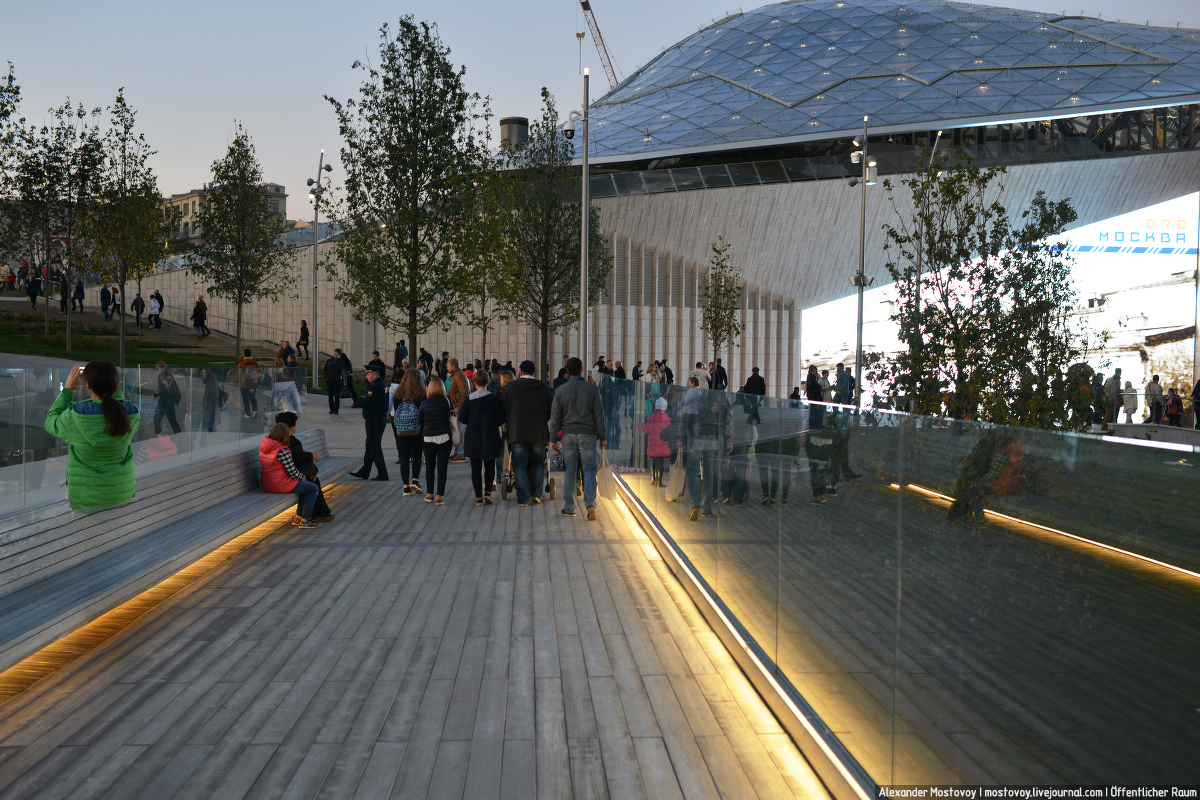

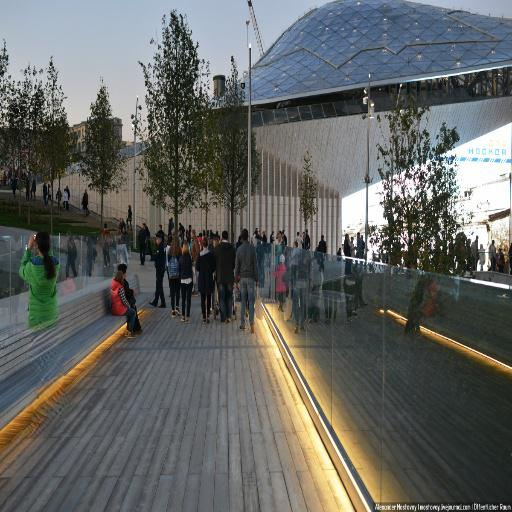

In [ ]:
#Show both Lama and CoModGan outputs 
cv2_imshow(cv2.imread('/content/output/1224276_original_mask.png')) #LaMa
cv2_imshow(cv2.imread('/content/co-mod-gan/imgs/output.jpg')) #Co-Mod-Gan